In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math, cmath
from scipy import integrate
from scipy.stats import norm

import timeit

%matplotlib inline

In [2]:
from numba import int32, float32,complex128    # import the types
from numba.experimental import jitclass
from numba import jit, generated_jit


In [3]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/PDE/Data/"


Mounted at /content/drive


# Black Scholes Base Class

In [11]:
class BlackScholes:
    @staticmethod
    def EurCall_BS(S,K,tau,sigma,r, q=0):
        d1 = BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        d2 = BlackScholes.d2_BS(S,K,tau,sigma,r,q=0)
        return S*np.exp(-q*tau)*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)
    @staticmethod
    def EurPut_BS(S,K,tau,sigma,r, q=0):
        d1 = BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        d2 = BlackScholes.d2_BS(S,K,tau,sigma,r,q=0)
        return  K*np.exp(-r*tau)*norm.cdf(-d2) - S*np.exp(-q*tau)*norm.cdf(-d1) 
        
    @staticmethod        
    def d1_BS(S,K,tau,sigma,r,q=0):
        d1 = (np.log(S/K) +( r- q + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        return d1
    @staticmethod        
    def d2_BS(S,K,tau,sigma,r,q=0):
        d2 = BlackScholes.d1_BS(S,K,tau,sigma,r,q)-sigma*np.sqrt(tau)
        return d2
    
    @staticmethod       
    def delta_call_BS(S,K,tau,sigma,r,q=0):
        return np.exp(-q*tau)*norm.cdf(BlackScholes.d1_BS(S,K,tau,sigma,r,q=0))   
    @staticmethod       
    def delta_put_BS(S,K,tau,sigma,r,q=0):
        return np.exp(-q*tau)*(norm.cdf(BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)) -1)
    
    @staticmethod       
    def vega_BS(S, K, tau, r, sigma, q=0):
        d1 =  BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        return S * norm.pdf(d1) * np.sqrt(tau) * np.exp(-q*tau) 

    @staticmethod
    def impliedVol(marketPrice, S,K,tau,r, q=0, IsCall=True, PRECISION = 1.0e-6):
        MAX_ITERATIONS = 200
        # PRECISION = 1.0e-6
        sigma = 0.5
        for i in range(0, MAX_ITERATIONS):
            if IsCall:
                modelPrice = BlackScholes.EurCall_BS(S,K,tau,sigma,r, q) 
            else:
                modelPrice = BlackScholes.EurPut_BS(S,K,tau,sigma,r, q) 

            vega = BlackScholes.vega_BS(S, K, tau, r, sigma,q)
            diff = marketPrice - modelPrice  # our root
            if (abs(diff) < PRECISION):
                return sigma
            sigma = sigma + diff/vega # f(x) / f'(x)
        return sigma # value wasn't found, return best guess so far

# Heston Model


$$ \frac{dS(t)}{S(t)} = rdt+\sqrt{V(t)}dW_1$$
$$ dV(t) = \lambda(\overline{V}(t) - V(t)) dt+\eta\sqrt{V(t)}dW_2$$
$$ dW_1 \dot dW_2 = \rho dt $$


## Transformation s.t. the integration is bounded but quad can handle inf bound and gives better performance so it is not using

$$ x= \ln(\frac{1}{t}) \Rightarrow dx = 1/(1/t) * (-1/t^2) dt = -\frac{1}{t} dt $$

$$ \int_0^\infty f(x) \;dx \Rightarrow \int_0^1 \frac{f(\ln(\frac{1}{t}))}{t} \;dt$$


## Heston class to calculate closed-form call price

In [5]:
class Heston2:
    def __init__(self,St,Vt,K,lamda,tau,v_bar,eta,rho,r=0,q=0, maxiter=500, tol=1e-6):
        self.St = St            # current underlying price (S0)
        self.Vt = Vt            # current underlying variance (V0)
        self.K = K              # strike price
        self.lamda = lamda      # variance mean reversion rate
        self.tau = tau          # T-t
        self.v_bar = v_bar      # long-term variance
        self.eta = eta          # vol of vol
        self.rho = rho          # correlation between 2 brownian motion
        self.r = r              # risk-free interest rate
        self.q = q              # dividend yield
        self.maxiter = maxiter
        self._preSet()
        self.i = complex(0,1)
        self.tol = 1e-6

    def _preSet(self):
      self.x = np.log(self.St*np.exp(self.r*self.tau)/self.K)
      self.gamma = 0.5*self.eta**2
    
    def _alpha(self,u):
      self.alpha_0 = -0.5*u**2 -0.5*u*self.i 
      self.alpha_1 = -0.5*u**2 +0.5*u*self.i 

    def _beta(self,u):
      self.beta_0 = self.lamda - self.rho*self.eta*self.i*u
      self.beta_1 = self.lamda - self.rho*self.eta - self.rho*self.eta*self.i*u

    def _d(self,u):
      self.d_0 = np.sqrt(self.beta_0**2 - 4*self.alpha_0*self.gamma)
      self.d_1 = np.sqrt(self.beta_1**2 - 4*self.alpha_1*self.gamma)

    def _R(self,u):
      self.R_pos_0 = (self.beta_0 + self.d_0)/(2*self.gamma)
      self.R_pos_1 = (self.beta_1 + self.d_1)/(2*self.gamma)
      self.R_neg_0 = (self.beta_0 - self.d_0)/(2*self.gamma)
      self.R_neg_1 = (self.beta_1 - self.d_1)/(2*self.gamma)

    def _g(self,u):
      self.g_0 = self.R_neg_0/self.R_pos_0
      self.g_1 = self.R_neg_1/self.R_pos_1

    def _D(self,u):
      self.D_0 = self.R_neg_0 * (1-np.exp(-self.d_0*self.tau))/(1-self.g_0*np.exp(-self.d_0*self.tau))
      self.D_1 = self.R_neg_1 * (1-np.exp(-self.d_1*self.tau))/(1-self.g_1*np.exp(-self.d_1*self.tau))

    def _C(self,u):
      self.C_0 = self.lamda * ( self.R_neg_0*self.tau - (1/self.gamma) * np.log( (1-self.g_0*np.exp(-self.d_0*self.tau))/(1-self.g_0) ))
      self.C_1 = self.lamda * ( self.R_neg_1*self.tau - (1/self.gamma) * np.log( (1-self.g_1*np.exp(-self.d_1*self.tau))/(1-self.g_1) ))
     
    def P_telda_0(self,u):
      self._alpha(u)
      self._beta(u)
      self._d(u)
      self._R(u)
      self._g(u)
      self._D(u)
      self._C(u)
      
      exp_term = self.C_0*self.v_bar + self.D_0*self.Vt + self.i*u*self.x
      P_telda_complex = np.exp(exp_term) /(self.i*u)

      return P_telda_complex.real

    def P_telda_1(self,u):
      self._alpha(u)
      self._beta(u)
      self._d(u)
      self._R(u)
      self._g(u)
      self._D(u)
      self._C(u)
      
      exp_term = self.C_1*self.v_bar + self.D_1*self.Vt + self.i*u*self.x
      P_telda_complex = np.exp(exp_term) /(self.i*u)

      return P_telda_complex.real
    
    def transformed_P_telda_0(self,u):
      return self.P_telda_0(np.log(1/u))/u
    def transformed_P_telda_1(self,u):
      return self.P_telda_1(np.log(1/u))/u

    def P_0_Int(self, useGaussianQuad, UB=100):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.P_telda_0,0,UB, maxiter=self.maxiter,  rtol = self.tol)
      else:
        val, err =  integrate.quad(self.P_telda_0, 0, np.inf, limit = self.maxiter, epsabs = self.tol)
      # print('Value of Gaussian Quadrature 0: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 0: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def P_0_transInt(self,useGaussianQuad):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.transformed_P_telda_0,0.0,1.0, maxiter=self.maxiter,  rtol = self.tol)
      else:
        val, err, =  integrate.quad(self.transformed_P_telda_0, 0.0, 1.0 , limit = self.maxiter, epsabs = self.tol)
      # print('Value of Gaussian Quadrature 0: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 0: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def P_1_Int(self,useGaussianQuad,UB=100):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.P_telda_1,0,UB, maxiter=self.maxiter ,  rtol = self.tol)
      else:
        val, err =  integrate.quad(self.P_telda_1, 0.0, np.inf, limit = self.maxiter , epsabs = self.tol)
      # print('Value of Gaussian Quadrature 1: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 1: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def P_1_transInt(self,useGaussianQuad):
      if useGaussianQuad:
        val, err =  integrate.quadrature(self.transformed_P_telda_1,0.0,1.0, maxiter=self.maxiter, rtol = self.tol)
      else:
        (val, err) =  integrate.quad(self.transformed_P_telda_1, 0.0, 1.0, limit = self.maxiter , epsabs = self.tol)

      # print('Value of Gaussian Quadrature 1: ',  0.5 + val/np.pi)
      # print('Error of Gaussian Quadrature 1: ', err)        # Difference between last two estimates of the integral.
      return 0.5 + val/np.pi

    def CallPrice(self,useTransInt= False, useGaussianQuad = False):
      if useTransInt:
        return self.K*np.exp(-self.r*self.tau)*( np.exp(self.x) * self.P_1_transInt(useGaussianQuad) - self.P_0_transInt(useGaussianQuad) )
      else:
        return self.K*np.exp(-self.r*self.tau)*( np.exp(self.x) * self.P_1_Int(useGaussianQuad) - self.P_0_Int(useGaussianQuad) )

    def setDetails(self, St, K, tau, r, q=0):
      self.St = St
      self.K = K
      self.tau = tau
      self.r = r
      self.q = q
      self._preSet()

    def printParams(self):
      print("St: ", self.St)
      print("K: ", self.K)
      print("tau: ", self.tau)
      print("r: ", self.r)
      print("q: ", self.q)
      print("lambda: ", self.lamda)
      print("eta: ", self.eta)
      print("v_bar: ", self.v_bar)
      print("Vt: ", self.Vt)
      print("rho: ", self.rho)
    



In [6]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate

  # lamda, v_bar, eta, rho, Vt = Params
initial_guess = (  5, 0.35**2, 0.3, 0.1,	0.5**2)


heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

In [7]:
%timeit Call = heston_obj.CallPrice(True, False)
# print("Call Price priced by Int & Gaussian Quadrature: ",Call)

10 loops, best of 5: 55.2 ms per loop


In [8]:
%timeit Call = heston_obj.CallPrice(False, False)
# print("Call Price priced by Int & quad: ",Call)

100 loops, best of 5: 10.2 ms per loop


# Sensitivity Analysis

In [ ]:
def plotSensitivity(result, group_label,x_label,y_label="CallPrice",title=None):
    x = sorted(result[x_label].unique())
    group = result[group_label].unique()
    result = result.set_index([group_label,x_label])

    for gp in group:
      y = result.loc[gp,y_label]
      plt.plot(x, y,label = group_label+" = " + str(gp))

    # naming the x axis
    plt.xlabel(x_label)
    # naming the y axis
    plt.ylabel(y_label)
    plt.legend()
    # giving a title to my graph
    if title is not None:
      plt.title(title)
    plt.show()

## $\eta$

In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(50,150,51)
result = pd.DataFrame()
i=0
eta_list = [0.1,0.5,0.9]
for eta in eta_list:
  for K in x:
    result.loc[i,'eta'] = eta
    result.loc[i,'K'] = K
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



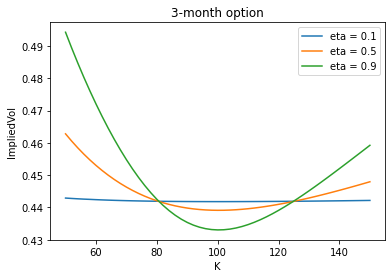

In [ ]:
plotSensitivity(result, 'eta' , 'K', y_label="ImpliedVol",title="3-month option")


## $\rho$

In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(50,150,51)
result = pd.DataFrame()
i=0
rho_list = [-0.1,0,0.1]
for rho in rho_list:
  for K in x:
    result.loc[i,'rho'] = rho
    result.loc[i,'K'] = K
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



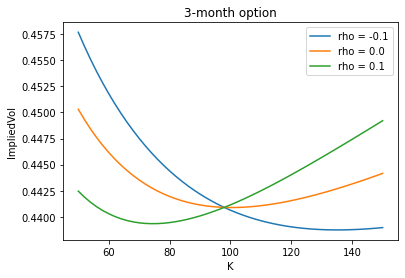

In [ ]:
plotSensitivity(result, 'rho' , 'K', y_label="ImpliedVol",title="3-month option")


## $V_t$

In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(0.01,2,51)
result = pd.DataFrame()
i=0
Vt_list = [0.1,0.25,1]
for Vt in Vt_list:
  for tau in x:
    result.loc[i,'Vt'] = Vt
    result.loc[i,'tau'] = tau
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



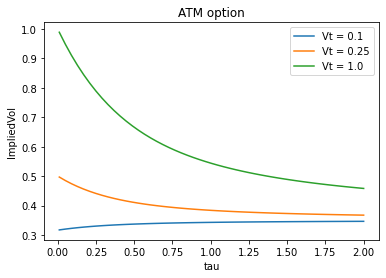

In [ ]:
plotSensitivity(result, 'Vt' , 'tau', y_label="ImpliedVol",title="ATM option")


In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(50,150,51)
result = pd.DataFrame()
i=0
Vt_list = [0.1,0.25,1]
for Vt in Vt_list:
  for K in x:
    result.loc[i,'Vt'] = Vt
    result.loc[i,'K'] = K
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



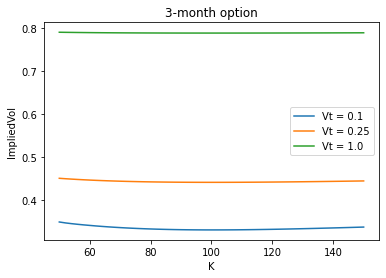

In [ ]:
plotSensitivity(result, 'Vt' , 'K', y_label="ImpliedVol",title="3-month option")

## $\overline{V}(t)$

In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(0.01,1,51)
result = pd.DataFrame()
i=0
v_bar_list = [0.1,0.25,1]
for v_bar in v_bar_list:
  for tau in x:
    result.loc[i,'v_bar'] = v_bar
    result.loc[i,'tau'] = tau
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



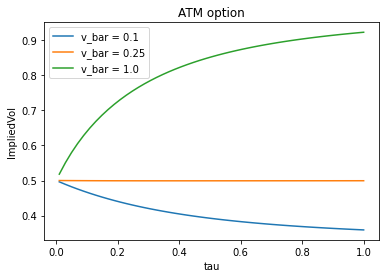

In [ ]:
plotSensitivity(result, 'v_bar' , 'tau', y_label="ImpliedVol",title="ATM option")


In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(50,150,51)
result = pd.DataFrame()
i=0
v_bar_list = [0.1,0.25,1]
for v_bar in v_bar_list:
  for K in x:
    result.loc[i,'v_bar'] = v_bar
    result.loc[i,'K'] = K
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



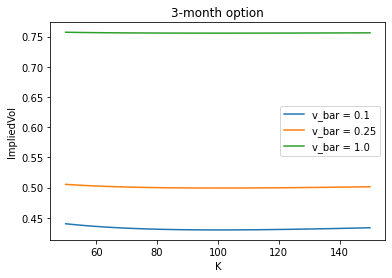

In [ ]:
plotSensitivity(result, 'v_bar' , 'K', y_label="ImpliedVol",title="3-month option")

## $\lambda$

In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(0.01,2,51)
result = pd.DataFrame()
i=0
lamda_list = [0.5,1,5]
for lamda in lamda_list:
  for tau in x:
    result.loc[i,'lambda'] = lamda
    result.loc[i,'tau'] = tau
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



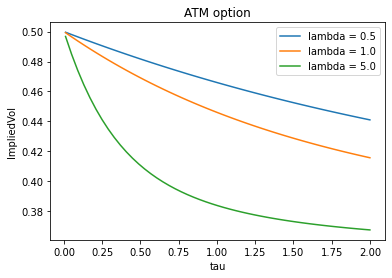

In [ ]:
plotSensitivity(result, 'lambda' , 'tau', y_label="ImpliedVol",title="ATM option")


In [ ]:
St = 100            # current underlying price (S0)
Vt = 0.5**2           # current underlying variance (V0)
K = 100              # strike price
lamda = 5      # variance mean reversion rate
tau = 3/12          # T-t
v_bar = 0.35**2      # long-term variance
eta = 0.3          # vol of vol
rho = 0          # correlation between 2 brownian motion
r = 0.014              # risk-free interest rate


# heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)

x =  np.linspace(50,150,51)
result = pd.DataFrame()
i=0
lamda_list = [0.5,1,5]
for lamda in lamda_list:
  for K in x:
    result.loc[i,'lambda'] = lamda
    result.loc[i,'K'] = K
    
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r)
    result.loc[i,'CallPrice'] = heston_obj.CallPrice()
    result.loc[i,'ImpliedVol'] =  BlackScholes.impliedVol(result.loc[i,'CallPrice'], St, K,tau,r, q=0, IsCall=True)

    i+=1



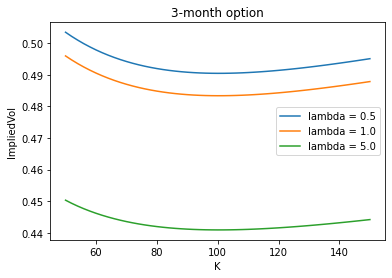

In [ ]:
plotSensitivity(result, 'lambda' , 'K', y_label="ImpliedVol",title="3-month option")

# Calibration

In [10]:
from scipy.optimize import minimize, NonlinearConstraint
from joblib import Parallel, delayed

In [11]:
def ErrorFunction_iter(St,K,tau,r,marketPrice,Vt,lamda,v_bar,eta,rho,weight):
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r,q=0)
    modelPrice = heston_obj.CallPrice()
    return weight*(marketPrice-modelPrice)**2 , weight, marketPrice-modelPrice

## Error function run on Colab

In [ ]:
def ErrorFunction(Params, marketData_Tb, ATM_weight, penalty=[0,0.05,0,0,0.05],target_Param=[5, 0.35**2, 0.3, 0.1, 0.5**2]):
    lamda, v_bar, eta, rho, Vt = Params
    print("lambda:",lamda,"; v_bar:", v_bar,"; eta:", eta,"; rho:", rho,"; Vt:",Vt )
    print("Constraint 2*lambda*v_bar - eta**2/2: ", 2*lamda*v_bar - 0.5*eta**2)

    sse = 0
    sumWeight = 0
    heston_obj = Heston2(100,Vt,100,lamda,1,v_bar,eta,rho,r=0,q=0)

    for i in marketData_Tb.index:
        St = marketData_Tb.loc[i,'S0']
        K = marketData_Tb.loc[i,'K']
        tau = marketData_Tb.loc[i,'tau']
        r = marketData_Tb.loc[i,'r']
        marketPrice = marketData_Tb.loc[i,"CallPrice"]
        weight = ATM_weight if marketData_Tb.loc[i,"ATM"] else 1
        
        se, w, e = ErrorFunction_iter(St,K,tau,r,marketPrice,Vt,lamda,v_bar,eta,rho,weight)
        sumWeight += w
        sse += se
        marketData_Tb.loc[i,"error"] = e
        
    MSE = sse/sumWeight
    err = MSE + sum(alpha*(TParam-Param)**2 for alpha,TParam,Param in zip(penalty,target_Param,Params) )
    print("MSE: ",MSE )
    print("Error: ",err )
    print("#########################")
    return err


## Error function run on PC (multiprocesser)

In [57]:
def mse(result):
    sse=0
    sumWeight=0
    
    for se, w,_ in result:
        sse+=se
        sumWeight+=w

    return sse/sumWeight

def ErrorFunction2(Params, marketData_Tb, ATM_weight, penalty=[0,0.05,0,0,0.05],target_Param=[5, 0.35**2, 0.3, 0.1, 0.5**2]):
    result = ErrorFun2_Core(Params, marketData_Tb, ATM_weight)
    MSE =  mse(result)
    err = MSE + sum(alpha*(TParam-Param)**2 for alpha,TParam,Param in zip(penalty,target_Param,Params) )
    print("MSE: ",MSE )
    print("Error: ",err )
    print("#########################")
    
    return err

def ErrorFun2_Core(Params, marketData_Tb, ATM_weight):
    lamda, v_bar, eta, rho, Vt = Params
    print("lambda:",lamda,"; v_bar:", v_bar,"; eta:", eta,"; rho:", rho,"; Vt:",Vt )
    print("Constraint 2*lambda*v_bar - eta**2/2: ", 2*lamda*v_bar - 0.5*eta**2)

    result = Parallel(n_jobs=6)(delayed(ErrorFunction_iter)(St =  marketData_Tb.loc[i,'S0'],
                                                          K = marketData_Tb.loc[i,'K'],
                                                          tau = marketData_Tb.loc[i,'tau'],
                                                          r = marketData_Tb.loc[i,'r'],
                                                          marketPrice =  marketData_Tb.loc[i,"CallPrice"],
                                                          Vt = Vt, lamda = lamda, v_bar = v_bar, eta = eta, rho = rho, 
                                                          weight = ATM_weight if marketData_Tb.loc[i,"ATM"] else 1 ) 
            for i in marketData_Tb.index )
    
    marketData_Tb.loc[:,"error"] = [res[2] for res in result]
    return result


def plotResult(marketData_Tb):
    tau_uni = marketData_Tb.tau.unique()
    for tau in tau_uni:
      ind = marketData_Tb.tau == tau
      x = marketData_Tb.loc[ind,'K'] / marketData_Tb.loc[ind,'S0']
      y = marketData_Tb.loc[ind,'error']
      plt.plot(x, y,label = "tau = " + "{:.2f}".format(tau))

    # naming the x axis
    plt.xlabel('Moneyness - K/S')
    # naming the y axis
    plt.ylabel('error')
    plt.title('marketPrice - modelPrice')
    plt.legend()
    # giving a title to my graph
    plt.show()


## Run Calibration

In [ ]:
pos_Vol = lambda Params: 2*Params[0]*Params[1] -Params[2]**2
constraint = NonlinearConstraint(pos_Vol,0,np.inf)

bounds = ((1e-3,50),(1e-3,10),(1e-3,5),(-1,1),(1e-3,1))

marketData_Tb =pd.read_csv(DATA_DIR+"CleanDataTable0502.csv")

ATM_weight = 100

initial_guess = (  1.35, 0.35**2, 0.3, 0.1,	0.53**2)


In [ ]:
# run optimizer
start = timeit.default_timer()

res = minimize(
    ErrorFunction,
    x0 = initial_guess,
    args = (marketData_Tb, ATM_weight),
    constraints = constraint,
    bounds = bounds,
    # method = "SLSQP"
)


stop = timeit.default_timer()

print('Time: ', stop - start)  

In [ ]:
res

     fun: 26.016656544551452
     jac: array([ 0.69889855,  8.65969157, -3.47312999, -6.72664833, -0.01275468])
 message: 'Optimization terminated successfully.'
    nfev: 613
     nit: 67
    njev: 66
  status: 0
 success: True
       x: array([3.26528752, 0.26349536, 1.3117836 , 1.        , 0.08227145])

In [ ]:
# Calculate prediction MSE without penalty
marketData_Tb =pd.read_csv(DATA_DIR+"CleanDataTable0503.csv")
ErrorFunction2(res.x , marketData_Tb, 1)

lambda: 5 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.25
Error:  0.04054755446476208


0.04054755446476208

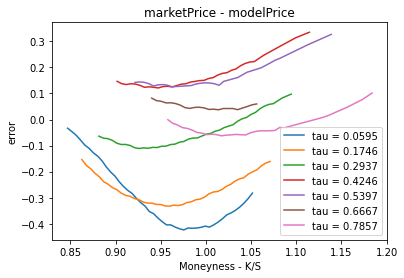

In [ ]:
# Error analysis
plotResult(marketData_Tb) 

# Calibration contract by contract

In [6]:
from scipy.optimize import minimize, NonlinearConstraint
from joblib import Parallel, delayed

In [14]:
def ErrorFunction_iter(St,K,tau,r,marketPrice,Vt,lamda,v_bar,eta,rho,weight):
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r,q=0)
    modelPrice = heston_obj.CallPrice()
    return weight*(marketPrice-modelPrice)**2 , weight, marketPrice-modelPrice

def ErrorFunction_IV_iter(marketIV,St,K,tau,r,Vt,lamda,v_bar,eta,rho,weight):
    heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r,q=0)
    modelPrice = heston_obj.CallPrice()
    modelIV = BlackScholes.impliedVol(modelPrice,St,K,tau,r,PRECISION=1e-7)
    return weight*(marketIV-modelIV)**2 , weight, marketIV-modelIV

In [102]:
def ErrorFunction(Params, marketData_Tb, ATM_weight, penalty=[0,0,0,0,0],target_Param=[1.35, 0.35**2, 0.3, 0.1, 0.5**2]):
    lamda, v_bar, eta, rho, Vt = Params
    print("lambda:",lamda,"; v_bar:", v_bar,"; eta:", eta,"; rho:", rho,"; Vt:",Vt )
    print("Constraint 2*lambda*v_bar - eta**2/2: ", 2*lamda*v_bar - 0.5*eta**2)

    sse = 0
    sumWeight = 0
    heston_obj = Heston2(100,Vt,100,lamda,1,v_bar,eta,rho,r=0,q=0)

    for i in marketData_Tb.index:
        St = marketData_Tb.loc[i,'S0']
        K = marketData_Tb.loc[i,'K']
        tau = marketData_Tb.loc[i,'tau']
        r = marketData_Tb.loc[i,'r']
        marketPrice = marketData_Tb.loc[i,"CallPrice"]
        weight = ATM_weight if marketData_Tb.loc[i,"ATM"] else 1
        
        se, w, e = ErrorFunction_iter(St,K,tau,r,marketPrice,Vt,lamda,v_bar,eta,rho,weight)
        sumWeight += w
        sse += se
        marketData_Tb.loc[i,"error"] = e
        
    MSE = sse/sumWeight
    err = MSE + sum(alpha*(TParam-Param)**2 for alpha,TParam,Param in zip(penalty,target_Param,Params) )
    print("MSE: ",MSE )
    print("Error: ",err )
    print("#########################")
    return err

def ErrorFunction_IV(Params, marketData_Tb, ATM_weight, penalty=[0,0,0,0,0],target_Param=[1.35, 0.35**2, 0.3, 0.1, 0.5**2]):
    lamda, v_bar, eta, rho, Vt = Params
    print("lambda:",lamda,"; v_bar:", v_bar,"; eta:", eta,"; rho:", rho,"; Vt:",Vt )
    print("Constraint 2*lambda*v_bar - eta**2/2: ", 2*lamda*v_bar - 0.5*eta**2)

    sse = 0
    sumWeight = 0
    heston_obj = Heston2(100,Vt,100,lamda,1,v_bar,eta,rho,r=0,q=0)

    for i in marketData_Tb.index:
        St = marketData_Tb.loc[i,'S0']
        K = marketData_Tb.loc[i,'K']
        tau = marketData_Tb.loc[i,'tau']
        r = marketData_Tb.loc[i,'r']
        marketPrice = marketData_Tb.loc[i,"CallPrice"]
        marketIV =  marketData_Tb.loc[i,"ImpVol_Market"]
        weight = ATM_weight if marketData_Tb.loc[i,"ATM"] else 1
        
        se, w, e = ErrorFunction_IV_iter(marketIV,St,K,tau,r,Vt,lamda,v_bar,eta,rho,weight)
        sumWeight += w
        sse += se
        marketData_Tb.loc[i,"error"] = e
        
    MSE = sse/sumWeight
    err = MSE + sum(alpha*(TParam-Param)**2 for alpha,TParam,Param in zip(penalty,target_Param,Params) )
    err = np.sqrt(err)*1000
    print("MSE: ",MSE )
    print("RMSE Error *1000: ",err )
    print("#########################")
    return err


In [114]:
def plot_IV(Params, marketData_Tb):
    lamda, v_bar, eta, rho, Vt = Params
    print("lambda:",lamda,"; v_bar:", v_bar,"; eta:", eta,"; rho:", rho,"; Vt:",Vt )
    print("Constraint 2*lambda*v_bar - eta**2/2: ", 2*lamda*v_bar - 0.5*eta**2)
  
    for i in marketData_Tb.index:
        St = marketData_Tb.loc[i,'S0']
        K = marketData_Tb.loc[i,'K']
        tau = marketData_Tb.loc[i,'tau']
        r = marketData_Tb.loc[i,'r']
        marketPrice = marketData_Tb.loc[i,"CallPrice"]

        heston_obj = Heston2(St,Vt,K,lamda,tau,v_bar,eta,rho,r,q=0)
        
        marketData_Tb.loc[i,'ModelCallPrice'] = ModelPrice = heston_obj.CallPrice()

        # marketData_Tb.loc[i,'ImpVol_Market'] = BlackScholes.impliedVol(marketPrice,St,K,tau,r)
        marketData_Tb.loc[i,'ImpVol_Model'] = BlackScholes.impliedVol(ModelPrice,St,K,tau,r)
    
    marketData_Tb.loc[:,'Moneyness_K_S'] = marketData_Tb['K']/marketData_Tb['S0']
    date_uni = marketData_Tb.Date.unique()
    # fig, axs = plt.subplots(int(np.ceil(len(date_uni)/2)),2 )
    fig, axs = plt.subplots(int(len(date_uni)) )#, figsize=(16,9) )
    fig.suptitle('Market ImpVol vs Model ImpVol')
    if len(date_uni)>1:
      for i in range(len(date_uni)):
        date = date_uni[i]
        ind = marketData_Tb.Date == date
        # axs[i//2, i%2].plot(marketData_Tb.loc[ind, 'Moneyness_K_S'  ],marketData_Tb.loc[ind,'ImpVol_Market'],label = 'ImpVol_Market')
        # axs[i//2, i%2].plot(marketData_Tb.loc[ind, 'Moneyness_K_S'  ],marketData_Tb.loc[ind,'ImpVol_Model'],label = 'ImpVol_Model')
        # axs[i//2, i%2].legend()
        # axs[i//2, i%2].set_title(date)

        axs[i].plot(marketData_Tb.loc[ind, 'Moneyness_K_S'  ],marketData_Tb.loc[ind,'ImpVol_Market'],label = 'ImpVol_Market')
        axs[i].plot(marketData_Tb.loc[ind, 'Moneyness_K_S'  ],marketData_Tb.loc[ind,'ImpVol_Model'],label = 'ImpVol_Model')
        axs[i].legend()
        axs[i].set_title(date)
    else:
        date = date_uni[0]
        ind = marketData_Tb.Date == date
        axs.plot(marketData_Tb.loc[ind, 'Moneyness_K_S'  ],marketData_Tb.loc[ind,'ImpVol_Market'],label = 'ImpVol_Market')
        axs.plot(marketData_Tb.loc[ind, 'Moneyness_K_S'  ],marketData_Tb.loc[ind,'ImpVol_Model'],label = 'ImpVol_Model')
        axs.legend()
        axs.set_title(date)


    fig.show()


In [117]:
marketData_Tb =pd.read_csv(DATA_DIR+"CleanData_2022Aug.csv")
marketData_Tb['ImpVol_Market'] = marketData_Tb.apply(lambda x:BlackScholes.impliedVol(x.CallPrice, x.S0, x.K,x.tau,x.r, q=0, IsCall=True,PRECISION=1e-7),axis=1)

marketData_InSample = marketData_Tb.loc[marketData_Tb.Date=='2022-05-02',:].copy()
marketData_OutSample = marketData_Tb.loc[marketData_Tb.Date=='2022-05-03',:].copy()


## Base Case

In [86]:
pos_Vol = lambda Params: 2*Params[0]*Params[1] -Params[2]**2
constraint = NonlinearConstraint(pos_Vol,0,np.inf)

bounds = ((1e-3,50),(1e-3,10),(1e-3,5),(-1,1),(1e-3,1))

ATM_weight = 100

initial_guess = (  1.35, 0.35**2, 0.3, 0.1,	0.53**2)
penalty = (0.1,1,0,0,1)

In [81]:
# run optimizer
start = timeit.default_timer()

res = minimize(
    ErrorFunction,
    x0 = initial_guess,
    args = (marketData_InSample, ATM_weight,penalty,initial_guess),
    constraints = constraint,
    bounds = bounds,
    # method = "SLSQP"
)


stop = timeit.default_timer()
print('Time: ', stop - start)  

lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.28575
MSE:  2.0238898491431807
Error:  2.0238898491431807
#########################
lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.28575
MSE:  2.0238898491431807
Error:  2.0238898491431807
#########################
lambda: 1.3500000149011613 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.2857500036507845
MSE:  2.0238898333522006
Error:  2.0238898333522006
#########################
lambda: 1.35 ; v_bar: 0.12250001490116118 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.2857500402331352
MSE:  2.023890005201977
Error:  2.0238900052019773
#########################
lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3000000149011612 ; rho: 0.1 ; Vt: 0.28090000000000004


In [82]:
res

     fun: 0.01089769994555731
     jac: array([ 0.00066575,  0.01531445, -0.00488031, -0.00013886,  0.02050229])
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([1.36498252, 0.10958137, 0.5469491 , 0.06398695, 0.21343304])

lambda: 1.36498251936491 ; v_bar: 0.10958137420229905 ; eta: 0.5469491044531094 ; rho: 0.06398694847642383 ; Vt: 0.2134330416586955
Constraint 2*lambda*v_bar - eta**2/2:  0.14957665903721704


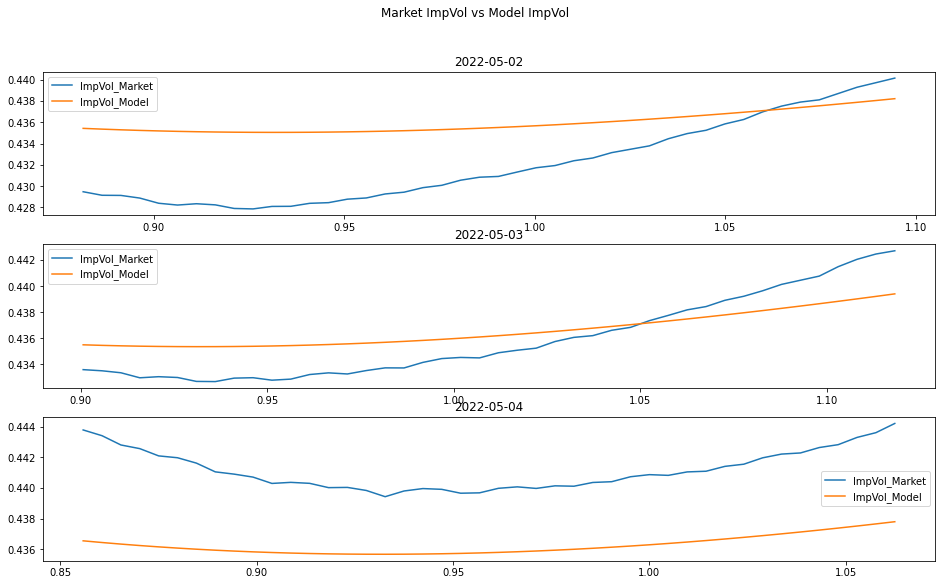

In [83]:
plot_IV(res.x, marketData_InSample)

In [79]:
plot_IV(res.x, marketData_InSample)

,Date,S0,K,tau,r,PutPrice,ATM,CallPrice,ModelCallPrice,ImpVol_Market,ImpVol_Model,Moneyness_K_S
0,2022-05-02,100.9641,89.0,0.2937,0.014,3.95,0,16.2792,16.386732,0.429478,0.435655,0.881501
1,2022-05-02,100.9641,89.5,0.2937,0.014,4.11,0,15.9413,16.056620,0.429146,0.435667,0.886454
2,2022-05-02,100.9641,90.0,0.2937,0.014,4.28,0,15.6133,15.730836,0.429132,0.435679,0.891406
3,2022-05-02,100.9641,90.5,0.2937,0.014,4.45,0,15.2854,15.409396,0.428884,0.435691,0.896358
4,2022-05-02,100.9641,91.0,0.2937,0.014,4.62,0,14.9574,15.092314,0.428397,0.435703,0.901310
...,...,...,...,...,...,...,...,...,...,...,...,...
127,2022-05-04,103.9974,108.5,0.2857,0.014,12.15,0,8.0805,7.959185,0.442636,0.437160,1.043295
128,2022-05-04,103.9974,109.0,0.2857,0.014,12.46,0,7.8925,7.767440,0.442823,0.437171,1.048103
129,2022-05-04,103.9974,109.5,0.2857,0.014,12.78,0,7.7145,7.579421,0.443296,0.437183,1.052911
130,2022-05-04,103.9974,110.0,0.2857,0.014,13.10,0,7.5365,7.395089,0.443606,0.437195,1.057719


## ATM = 10

In [85]:
pos_Vol = lambda Params: 2*Params[0]*Params[1] -Params[2]**2
constraint = NonlinearConstraint(pos_Vol,0,np.inf)

bounds = ((1e-3,50),(1e-3,10),(1e-3,5),(-1,1),(1e-3,1))

ATM_weight = 10

initial_guess = (  1.35, 0.35**2, 0.3, 0.1,	0.53**2)
penalty = (0.1,1,0,0,1)

# run optimizer
start = timeit.default_timer()

res = minimize(
    ErrorFunction,
    x0 = initial_guess,
    args = (marketData_InSample, ATM_weight,penalty,initial_guess),
    constraints = constraint,
    bounds = bounds,
    # method = "SLSQP"
)


stop = timeit.default_timer()
print('Time: ', stop - start)  

lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.28575
MSE:  1.9078093882639353
Error:  1.9078093882639353
#########################
lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.28575
MSE:  1.9078093882639353
Error:  1.9078093882639353
#########################
lambda: 1.3500000149011613 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.2857500036507845
MSE:  1.9078093732602204
Error:  1.9078093732602204
#########################
lambda: 1.35 ; v_bar: 0.12250001490116118 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.2857500402331352
MSE:  1.9078095365343437
Error:  1.907809536534344
#########################
lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3000000149011612 ; rho: 0.1 ; Vt: 0.28090000000000004


In [87]:
res

     fun: 0.011252055305035914
     jac: array([ 0.00111325,  0.01380603, -0.00520849,  0.00073045, -0.00109373])
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([1.36476738, 0.1109653 , 0.55034876, 0.09721489, 0.21327341])

lambda: 1.3647673777793554 ; v_bar: 0.11096530099701321 ; eta: 0.5503487626802573 ; rho: 0.0972148897840389 ; Vt: 0.21327340976890286
Constraint 2*lambda*v_bar - eta**2/2:  0.15144176544053614


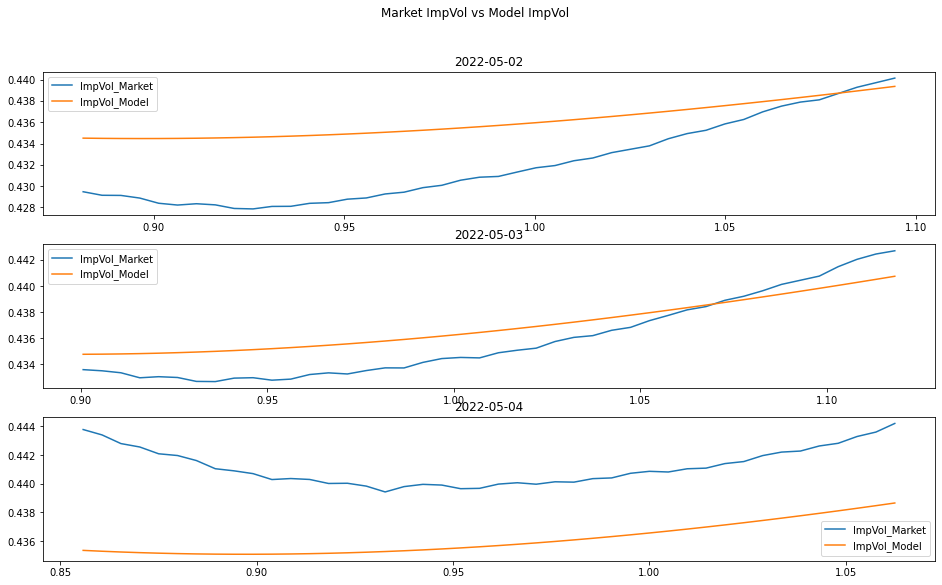

In [88]:
plot_IV(res.x, marketData_InSample)

lambda: 1.3647673777793554 ; v_bar: 0.11096530099701321 ; eta: 0.5503487626802573 ; rho: 0.0972148897840389 ; Vt: 0.21327340976890286
Constraint 2*lambda*v_bar - eta**2/2:  0.15144176544053614


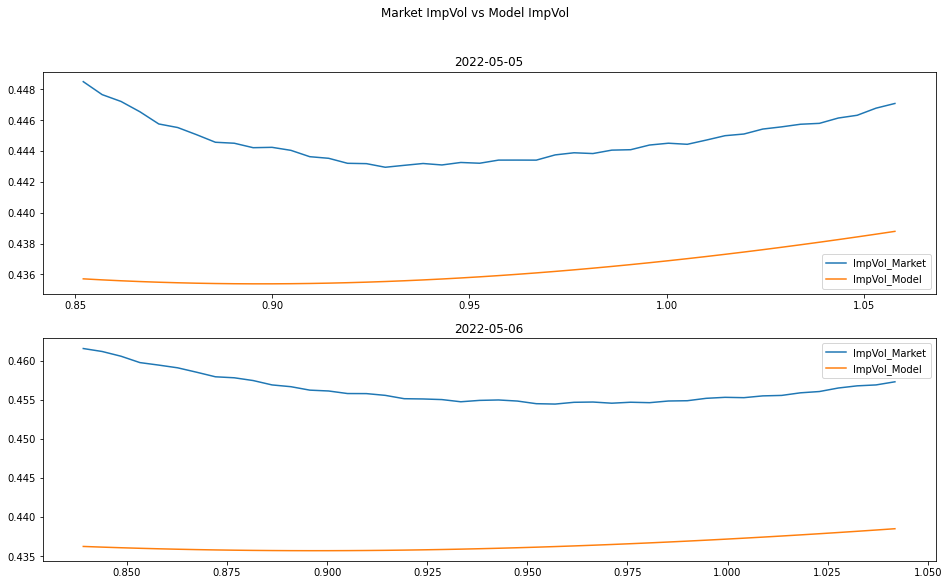

In [90]:
plot_IV(res.x, marketData_OutSample)

## Calibrate with IV error function

In [100]:
pos_Vol = lambda Params: 2*Params[0]*Params[1] -Params[2]**2
constraint = NonlinearConstraint(pos_Vol,0,np.inf)

bounds = ((1e-3,50),(1e-3,10),(1e-3,5),(-1,1),(1e-3,1))

ATM_weight = 10

initial_guess = (  1.35, 0.35**2, 0.3, 0.1,	0.53**2)
penalty = (0.1,1,0,0,1)

# run optimizer
start = timeit.default_timer()

res = minimize(
    ErrorFunction_IV,
    x0 = initial_guess,
    args = (marketData_InSample, ATM_weight,penalty,initial_guess),
    constraints = constraint,
    bounds = bounds,
    # method = "SLSQP"
)


stop = timeit.default_timer()
print('Time: ', stop - start)  

lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.28575
MSE:  0.004888466568695271
Error:  0.004888466568695271
#########################
lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.28575
MSE:  0.004888466568695271
Error:  0.004888466568695271
#########################
lambda: 1.3500000149011613 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.2857500036507845
MSE:  0.004888466531994564
Error:  0.004888466531994587
#########################
lambda: 1.35 ; v_bar: 0.12250001490116118 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.2857500402331352
MSE:  0.004888466932182174
Error:  0.004888466932182396
#########################
lambda: 1.35 ; v_bar: 0.12249999999999998 ; eta: 0.3000000149011612 ; rho: 0.1 ; Vt: 0.2

In [101]:
res

     fun: 0.0024496429174446542
     jac: array([ 3.06577742e-04,  4.02713055e-03, -1.57769988e-03,  3.01143416e-04,
        5.46802476e-05])
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([1.35703063, 0.11738841, 0.56444615, 0.04097359, 0.24848478])

lambda: 1.3570306307056443 ; v_bar: 0.11738840551988956 ; eta: 0.5644461488620712 ; rho: 0.04097358927539451 ; Vt: 0.24848478341009514
Constraint 2*lambda*v_bar - eta**2/2:  0.1592995964777596


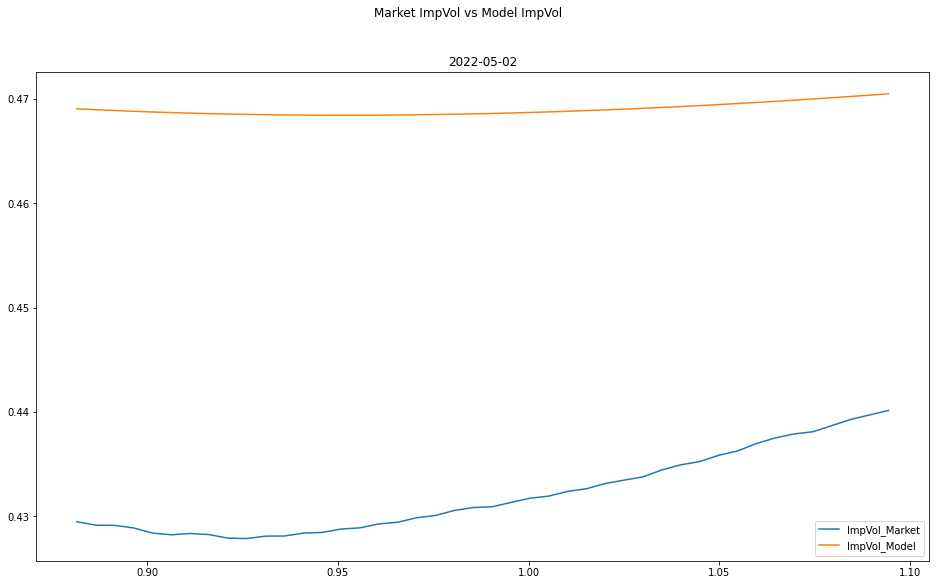

In [104]:
plot_IV(res.x, marketData_InSample)

### Calibrate with IV error function - No Penalty



In [62]:
pos_Vol = lambda Params: 2*Params[0]*Params[1] -Params[2]**2
constraint = NonlinearConstraint(pos_Vol,0,np.inf)

bounds = ((1e-3,50),(1e-3,5),(1e-3,3),(-1,1),(1e-3,1))

ATM_weight = 100

initial_guess = (  2.0, 0.35**2, 0.3, 0.1,	0.53**2)
penalty = (0,0,0,0,0)

# run optimizer
start = timeit.default_timer()

res = minimize(
    ErrorFunction_IV,
    x0 = initial_guess,
    args = (marketData_InSample, ATM_weight,penalty,initial_guess),
    constraints = constraint,
    bounds = bounds,
    # method = "SLSQP"
)


stop = timeit.default_timer()
print('Time: ', stop - start)  

lambda: 2.0 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.44499999999999995
MSE:  0.003504140031853172
RMSE Error *1000:  59.195777145444865
#########################
lambda: 2.0 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.44499999999999995
MSE:  0.003504140031853172
RMSE Error *1000:  59.195777145444865
#########################
lambda: 2.000000014901161 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.44500000365078446
MSE:  0.003504140003719717
RMSE Error *1000:  59.19577690781426
#########################
lambda: 2.0 ; v_bar: 0.12250001490116118 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.4450000596046447
MSE:  0.003504140471383035
RMSE Error *1000:  59.19578085795503
#########################
lambda: 2.0 ; v_bar: 0.1224999999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhap

MSE:  nan
RMSE Error *1000:  nan
#########################
lambda: 3.594711971282959 ; v_bar: 0.11035000202075251 ; eta: 0.7699999999636915 ; rho: -0.009999999975984553 ; Vt: 0.25291000625323107
Constraint 2*lambda*v_bar - eta**2/2:  0.49690294661815315
MSE:  2.789912862798183e-05
RMSE Error *1000:  5.281962573512031
#########################
lambda: 3.594711971282959 ; v_bar: 0.11035000202075251 ; eta: 0.7699999999636915 ; rho: -0.009999999975984553 ; Vt: 0.25291000625323107
Constraint 2*lambda*v_bar - eta**2/2:  0.49690294661815315
MSE:  2.789912862798183e-05
RMSE Error *1000:  5.281962573512031
#########################
lambda: 3.5947119861841204 ; v_bar: 0.11035000202075251 ; eta: 0.7699999999636915 ; rho: -0.009999999975984553 ; Vt: 0.25291000625323107
Constraint 2*lambda*v_bar - eta**2/2:  0.4969029499068395
MSE:  2.7899127037753572e-05
RMSE Error *1000:  5.281962422978184
#########################
lambda: 3.594711971282959 ; v_bar: 0.11035001692191371 ; eta: 0.7699999999636915 ;

In [63]:
res

     fun: 0.13951223060974025
     jac: array([ 0.00194708,  0.18056151, -0.0132043 ,  0.00604635,  0.21144566])
 message: 'Optimization terminated successfully.'
    nfev: 201
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([4.44609816, 0.20014802, 1.33407477, 0.14481377, 0.20244439])

lambda: 6.42036677 ; v_bar: 0.20238798 ; eta: 1.61201301 ; rho: 0.14342213 ; Vt: 0.20114263
Constraint 2*lambda*v_bar - eta**2/2:  1.299517150674219


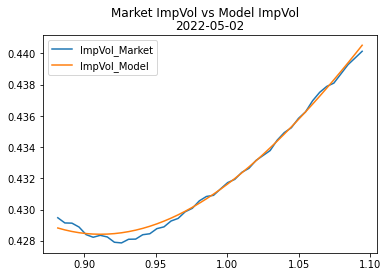

In [118]:
Param = [6.42036677, 0.20238798, 1.61201301, 0.14342213, 0.20114263]

plot_IV(Param, marketData_InSample)

In [120]:
param = [p for p in Param]
param[4] = param[4] + param[0]*(param[1]-param[4])/252
param

[6.42036677, 0.20238798, 1.61201301, 0.14342213, 0.20117435858633737]

lambda: 6.42036677 ; v_bar: 0.20238798 ; eta: 1.61201301 ; rho: 0.14342213 ; Vt: 0.20117435858633737
Constraint 2*lambda*v_bar - eta**2/2:  1.299517150674219


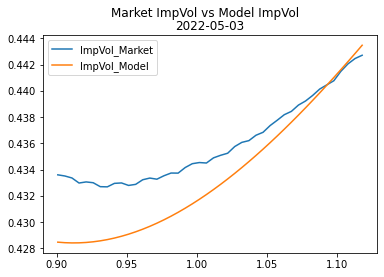

In [121]:
plot_IV(param, marketData_OutSample)

### Comparison

In [122]:
orig_param = [1.3709,	0.0806,	0.4701,	0.0134,	0.2153]

lambda: 1.3709 ; v_bar: 0.0806 ; eta: 0.4701 ; rho: 0.0134 ; Vt: 0.2153
Constraint 2*lambda*v_bar - eta**2/2:  0.110492075


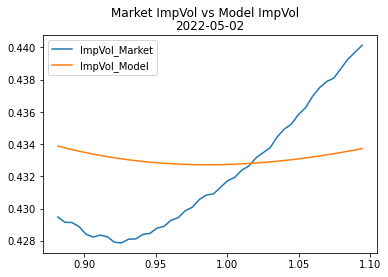

In [123]:
plot_IV(orig_param, marketData_InSample)

lambda: 1.3709 ; v_bar: 0.0806 ; eta: 0.4701 ; rho: 0.0134 ; Vt: 0.2153
Constraint 2*lambda*v_bar - eta**2/2:  0.110492075


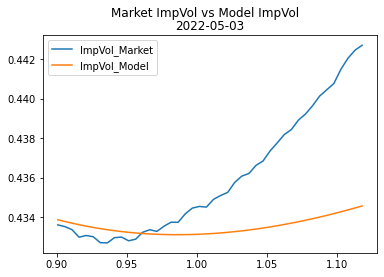

In [124]:
plot_IV(orig_param, marketData_OutSample)

lambda: 1.3709 ; v_bar: 0.0806 ; eta: 0.4701 ; rho: 0.0134 ; Vt: 0.2153
Constraint 2*lambda*v_bar - eta**2/2:  0.110492075
MSE:  1.4908408577741823e-05
RMSE Error:  0.38611408388896956
#########################


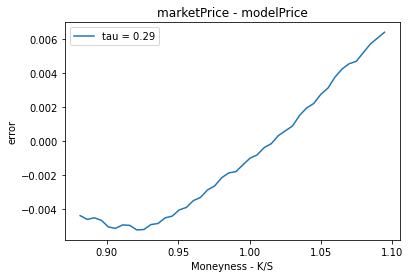

In [59]:
ErrorFunction_IV(orig_param , marketData_InSample, 1)
# Error analysis
plotResult(marketData_InSample) 

lambda: 1.3709 ; v_bar: 0.0806 ; eta: 0.4701 ; rho: 0.0134 ; Vt: 0.2153
Constraint 2*lambda*v_bar - eta**2/2:  0.110492075
MSE:  1.3483841974337674e-05
RMSE Error:  0.36720351270566126
#########################


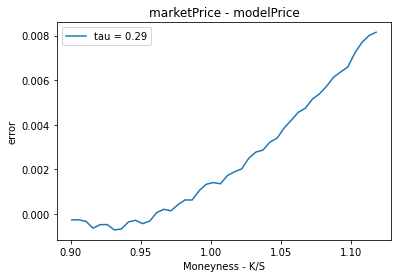

In [60]:
ErrorFunction_IV(orig_param , marketData_OutSample, 1)
# Error analysis
plotResult(marketData_OutSample) 

### validation

In [67]:
marketData_Tb =pd.read_csv(DATA_DIR+"CleanData_2022Aug.csv")
marketData_Tb.Date.unique()


array(['2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05',
       '2022-05-06'], dtype=object)

In [86]:
marketData_Tb =pd.read_csv(DATA_DIR+"CleanData_2022Aug.csv")
marketData_Tb['ImpVol_Market'] = marketData_Tb.apply(lambda x:BlackScholes.impliedVol(x.CallPrice, x.S0, x.K,x.tau,x.r, q=0, IsCall=True,PRECISION=1e-7),axis=1)
dateList = ['2022-05-02','2022-05-03','2022-05-04','2022-05-05','2022-05-06']
penalty_default = [0.1,  1, 0, 0, 1]


result = pd.DataFrame()
for alpha in [0,0.5,1.0,2.0]:
    for lamda in [0.5,1.0,2.0]:
        penalty = [pen*alpha for pen in penalty_default]
        initial_guess = (lamda, 0.35**2, 0.3, 0.1, 0.53**2)

        err_list=[]
        for i in range(len(dateList)-1):
            marketData_InSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i],:].copy()
            marketData_OutSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i+1],:].copy()

            res = minimize(
                ErrorFunction_IV,
                x0 = initial_guess,
                args = (marketData_InSample, ATM_weight,penalty,initial_guess),
                constraints = constraint,
                bounds = bounds,
                #     method = "SLSQP"
            )
            initial_guess = res.x
            
            err_list.append( ErrorFunction_IV( res.x, marketData_Tb, ATM_weight, penalty=[0,0,0,0,0],target_Param=[1.35, 0.35**2, 0.3, 0.1, 0.5**2]) )

        err_arr = np.array(err_list)/1000
        result_temp = {'alpha':alpha, 'lamda':lamda, 'RMSE_Mean':err_arr.mean(), 'RMSE_Std':err_arr.std() }
        result = result.append(result_temp,ignore_index=True)
        

lambda: 0.5 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.07749999999999999
MSE:  0.007413694818131335
RMSE Error *1000:  86.10281539027243
#########################
lambda: 0.5 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.07749999999999999
MSE:  0.007413694818131335
RMSE Error *1000:  86.10281539027243
#########################
lambda: 0.5000000149011612 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.07750000365078448
MSE:  0.00741369476656848
RMSE Error *1000:  86.10281509084636
#########################
lambda: 0.5 ; v_bar: 0.12250001490116118 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.07750001490116118
MSE:  0.007413694992268867
RMSE Error *1000:  86.102816401491
#########################
lambda: 0.5 ; v_bar: 0.1224999999999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhap

MSE:  nan
RMSE Error *1000:  nan
#########################
lambda: 2.509414291381836 ; v_bar: 0.11034999999999999 ; eta: 0.77 ; rho: -0.010000000000000009 ; Vt: 0.25291
Constraint 2*lambda*v_bar - eta**2/2:  0.25737773410797116
MSE:  0.0003145291346699907
RMSE Error *1000:  17.73496926047493
#########################
lambda: 2.509414291381836 ; v_bar: 0.11034999999999999 ; eta: 0.77 ; rho: -0.010000000000000009 ; Vt: 0.25291
Constraint 2*lambda*v_bar - eta**2/2:  0.25737773410797116
MSE:  0.0003145291346699907
RMSE Error *1000:  17.73496926047493
#########################
lambda: 2.509414306282997 ; v_bar: 0.11034999999999999 ; eta: 0.77 ; rho: -0.010000000000000009 ; Vt: 0.25291
Constraint 2*lambda*v_bar - eta**2/2:  0.2573777373966575
MSE:  0.000314529128009567
RMSE Error *1000:  17.73496907269835
#########################
lambda: 2.509414291381836 ; v_bar: 0.11035001490116118 ; eta: 0.77 ; rho: -0.010000000000000009 ; Vt: 0.25291
Constraint 2*lambda*v_bar - eta**2/2:  0.257377808894

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: IntegrationWarning: The integral is probably divergent, or slowly convergent.


Streaming output truncated to the last 5000 lines.
MSE:  1.6508573054115048e-08
RMSE Error *1000:  0.12848569202099916
#########################
lambda: 6.354135097765004 ; v_bar: 0.21710302353569175 ; eta: 1.5585175215353142 ; rho: 0.07652355345111858 ; Vt: 0.20062924377325095
Constraint 2*lambda*v_bar - eta**2/2:  1.5445154508917924
MSE:  1.6508594542502344e-08
RMSE Error *1000:  0.12848577564268485
#########################
lambda: 6.354135097765004 ; v_bar: 0.21710302353569175 ; eta: 1.558517506634153 ; rho: 0.07652356835227977 ; Vt: 0.20062924377325095
Constraint 2*lambda*v_bar - eta**2/2:  1.5445154741155132
MSE:  1.6508593377314206e-08
RMSE Error *1000:  0.12848577110837683
#########################
lambda: 6.354135097765004 ; v_bar: 0.21710302353569175 ; eta: 1.558517506634153 ; rho: 0.07652355345111858 ; Vt: 0.20062925867441214
Constraint 2*lambda*v_bar - eta**2/2:  1.5445154741155132
MSE:  1.650857680184184e-08
RMSE Error *1000:  0.12848570660521677
#########################


KeyboardInterrupt: ignored

In [87]:
result

,alpha,lamda,RMSE_Mean,RMSE_Std
0,0.0,0.5,0.009410,0.001585
1,0.0,1.0,0.009372,0.001424
2,0.0,2.0,0.009756,0.001194


### plot final graph

lambda: 1.0 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.19999999999999996
MSE:  0.005842175672319623
RMSE Error *1000:  76.43412635936663
#########################
lambda: 1.0 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.19999999999999996
MSE:  0.005842175672319623
RMSE Error *1000:  76.43412635936663
#########################
lambda: 1.0000000149011612 ; v_bar: 0.12249999999999998 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.20000000365078446
MSE:  0.005842175629949609
RMSE Error *1000:  76.43412608219975
#########################
lambda: 1.0 ; v_bar: 0.12250001490116118 ; eta: 0.3 ; rho: 0.1 ; Vt: 0.28090000000000004
Constraint 2*lambda*v_bar - eta**2/2:  0.20000002980232234
MSE:  0.005842175972750772
RMSE Error *1000:  76.43412832466117
#########################
lambda: 1.0 ; v_bar: 0.1224999999

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhap

MSE:  nan
RMSE Error *1000:  nan
#########################
lambda: 2.8600354194641113 ; v_bar: 0.1103500026329135 ; eta: 0.7699999998815807 ; rho: -0.009999999929778847 ; Vt: 0.25291001705167304
Constraint 2*lambda*v_bar - eta**2/2:  0.33475983222736394
MSE:  0.00018061042110182582
RMSE Error *1000:  13.439137662135389
#########################
lambda: 2.8600354194641113 ; v_bar: 0.1103500026329135 ; eta: 0.7699999998815807 ; rho: -0.009999999929778847 ; Vt: 0.25291001705167304
Constraint 2*lambda*v_bar - eta**2/2:  0.33475983222736394
MSE:  0.00018061042110182582
RMSE Error *1000:  13.439137662135389
#########################
lambda: 2.8600354343652725 ; v_bar: 0.1103500026329135 ; eta: 0.7699999998815807 ; rho: -0.009999999929778847 ; Vt: 0.25291001705167304
Constraint 2*lambda*v_bar - eta**2/2:  0.33475983551605026
MSE:  0.0001806104163342549
RMSE Error *1000:  13.439137484759016
#########################
lambda: 2.8600354194641113 ; v_bar: 0.1103500175340747 ; eta: 0.76999999988158

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app


MSE:  nan
RMSE Error *1000:  nan
#########################
lambda: 3.188172490006117 ; v_bar: 0.09941500435850739 ; eta: 0.7788973003069162 ; rho: -0.10899999404906473 ; Vt: 0.2277190166972321
Constraint 2*lambda*v_bar - eta**2/2:  0.3305638617665618
MSE:  0.0002316407367112304
RMSE Error *1000:  15.21974824730128
#########################
lambda: 3.014176261271017 ; v_bar: 0.10521333874915932 ; eta: 0.7741794648079448 ; rho: -0.056504780408313575 ; Vt: 0.24107666340413228
Constraint 2*lambda*v_bar - eta**2/2:  0.33458617418840625
MSE:  5.3668379320557856e-06
RMSE Error *1000:  2.3166436782672872
#########################
lambda: 3.014176261271017 ; v_bar: 0.10521333874915932 ; eta: 0.7741794648079448 ; rho: -0.056504780408313575 ; Vt: 0.24107666340413228
Constraint 2*lambda*v_bar - eta**2/2:  0.33458617418840625
MSE:  5.3668379320557856e-06
RMSE Error *1000:  2.3166436782672872
#########################
lambda: 3.014176276172178 ; v_bar: 0.10521333874915932 ; eta: 0.7741794648079448 ;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhap

MSE:  nan
RMSE Error *1000:  nan
#########################
lambda: 5.702056022158404 ; v_bar: 0.24012485165243275 ; eta: 1.4842485301105983 ; rho: 0.10311836684625347 ; Vt: 0.17346081705370064
Constraint 2*lambda*v_bar - eta**2/2:  1.6369138633015594
MSE:  3.396494972119807e-05
RMSE Error *1000:  5.827945583239266
#########################
lambda: 6.117615166367717 ; v_bar: 0.23541738165100184 ; eta: 1.5427045082824458 ; rho: 0.031434817134691685 ; Vt: 0.1872448026941179
Constraint 2*lambda*v_bar - eta**2/2:  1.6904172888920004
MSE:  8.559384911948903e-07
RMSE Error *1000:  0.9251694391812185
#########################
lambda: 6.117615166367717 ; v_bar: 0.23541738165100184 ; eta: 1.5427045082824458 ; rho: 0.031434817134691685 ; Vt: 0.1872448026941179
Constraint 2*lambda*v_bar - eta**2/2:  1.6904172888920004
MSE:  8.559384911948903e-07
RMSE Error *1000:  0.9251694391812185
#########################
lambda: 6.117615181268878 ; v_bar: 0.23541738165100184 ; eta: 1.5427045082824458 ; rho: 0.

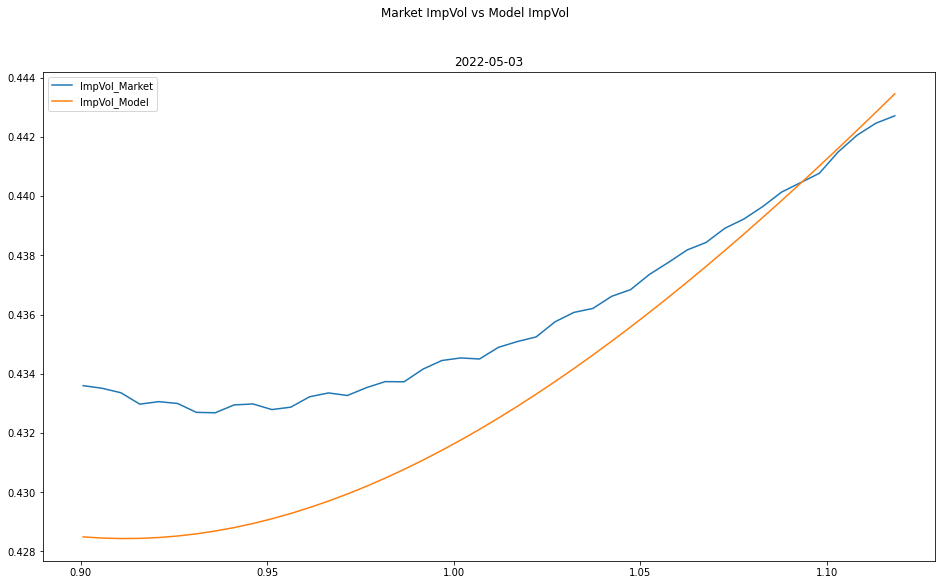

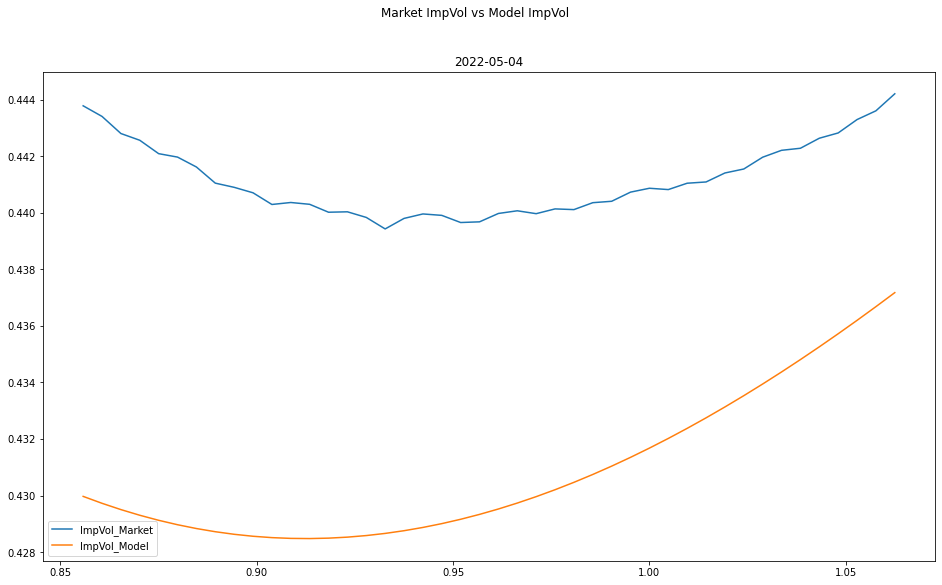

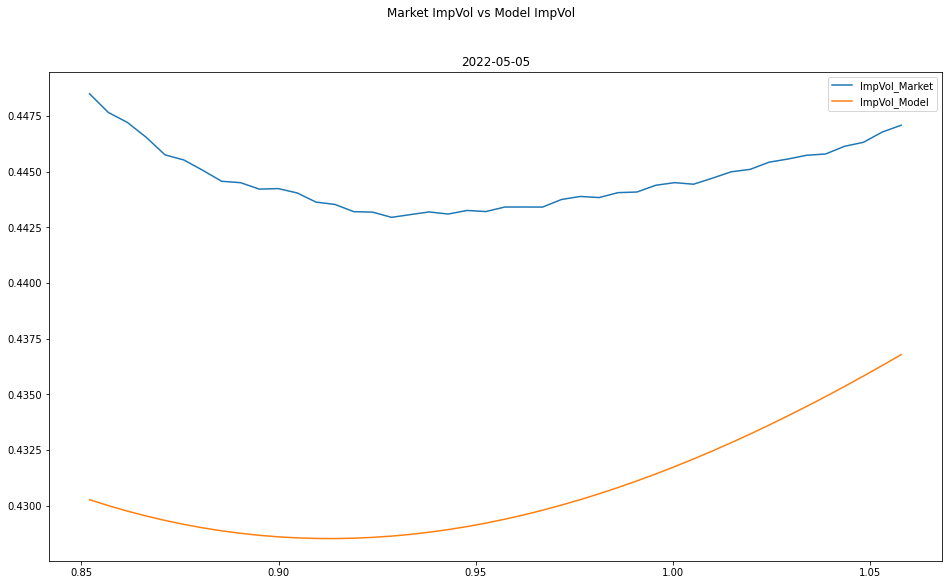

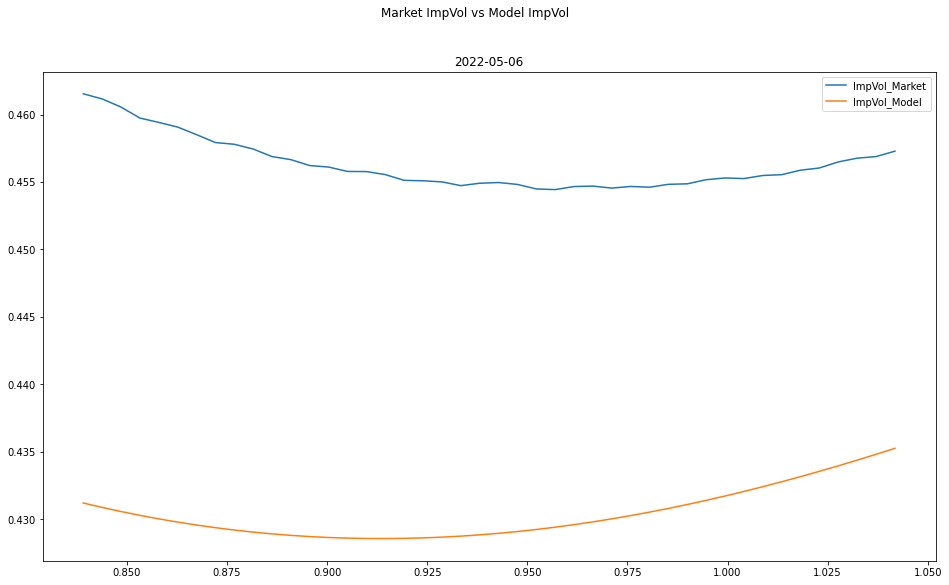

In [89]:
penalty = [0,  0, 0, 0, ]
initial_guess = (1.0, 0.35**2, 0.3, 0.1, 0.53**2)
param_list =[]
err_list=[]
for i in range(len(dateList)-1):
    marketData_InSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i],:].copy()
    marketData_OutSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i+1],:].copy()

    res = minimize(
        ErrorFunction_IV,
        x0 = initial_guess,
        args = (marketData_InSample, ATM_weight,penalty,initial_guess),
        constraints = constraint,
        bounds = bounds,
        #     method = "SLSQP"
    )
    initial_guess = res.x
    param_list.append(res.x)
    print(dateList[i]," - Parameters: ",res.x)
    plot_IV( res.x, marketData_OutSample)

In [90]:
param_list

[array([6.42036677, 0.20238798, 1.61201301, 0.14342213, 0.20114263]),
 array([6.41886295, 0.20021133, 1.50618897, 0.09460406, 0.20605098]),
 array([6.35477026, 0.21725169, 1.55980139, 0.07661896, 0.20049433]),
 array([6.19907738, 0.21552632, 1.58377958, 0.07931718, 0.21154332])]

In [104]:
initial_guess = (6.35477026, 0.21725169, 1.55980139, 0.07661896, 0.20049433)
penalty = [0,0,0,0,0]
param_list =[]
err_list=[]
marketData_InSample = marketData_Tb.loc[marketData_Tb.Date == '2022-05-05',:].copy()
marketData_OutSample = marketData_Tb.loc[marketData_Tb.Date == '2022-05-06',:].copy()

res = minimize(
    ErrorFunction_IV,
    x0 = initial_guess,
    args = (marketData_InSample, ATM_weight,penalty,initial_guess),
    constraints = constraint,
    bounds = bounds,
    #     method = "SLSQP"
)


lambda: 6.35477026 ; v_bar: 0.21725169 ; eta: 1.55980139 ; rho: 0.07661896 ; Vt: 0.20049433
Constraint 2*lambda*v_bar - eta**2/2:  1.5446789689705123
MSE:  1.359419622859967e-05
RMSE Error *1000:  3.6870308147070956
#########################
lambda: 6.35477026 ; v_bar: 0.21725169 ; eta: 1.55980139 ; rho: 0.07661896 ; Vt: 0.20049433
Constraint 2*lambda*v_bar - eta**2/2:  1.5446789689705123
MSE:  1.359419622859967e-05
RMSE Error *1000:  3.6870308147070956
#########################
lambda: 6.354770274901161 ; v_bar: 0.21725169 ; eta: 1.55980139 ; rho: 0.07661896 ; Vt: 0.20049433
Constraint 2*lambda*v_bar - eta**2/2:  1.5446789754451171
MSE:  1.3594195860627622e-05
RMSE Error *1000:  3.6870307648062313
#########################
lambda: 6.35477026 ; v_bar: 0.2172517049011612 ; eta: 1.55980139 ; rho: 0.07661896 ; Vt: 0.20049433
Constraint 2*lambda*v_bar - eta**2/2:  1.5446791583574242
MSE:  1.359412891995108e-05
RMSE Error *1000:  3.6870216869379924
#########################
lambda: 6.354770

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhap

MSE:  nan
RMSE Error *1000:  nan
#########################
lambda: 5.701877490406469 ; v_bar: 0.2401275970347862 ; eta: 1.4842500846226878 ; rho: 0.1031177441641021 ; Vt: 0.17345714666318746
Constraint 2*lambda*v_bar - eta**2/2:  1.636857123864857
MSE:  3.398358980588039e-05
RMSE Error *1000:  5.829544562474876
#########################
lambda: 6.1175786938180545 ; v_bar: 0.23542049973208745 ; eta: 1.5427048429691292 ; rho: 0.03143192195109562 ; Vt: 0.18724126634511848
Constraint 2*lambda*v_bar - eta**2/2:  1.6904377502378316
MSE:  8.562249498926575e-07
RMSE Error *1000:  0.9253242404112503
#########################
lambda: 6.1175786938180545 ; v_bar: 0.23542049973208745 ; eta: 1.5427048429691292 ; rho: 0.03143192195109562 ; Vt: 0.18724126634511848
Constraint 2*lambda*v_bar - eta**2/2:  1.6904377502378316
MSE:  8.562249498926575e-07
RMSE Error *1000:  0.9253242404112503
#########################
lambda: 6.117578708719216 ; v_bar: 0.23542049973208745 ; eta: 1.5427048429691292 ; rho: 0.0

In [109]:
res.x

array([6.19910408, 0.21553377, 1.58378745, 0.0793168 , 0.21153479])

lambda: 6.42036677 ; v_bar: 0.20238798 ; eta: 1.61201301 ; rho: 0.14342213 ; Vt: 0.20114263
Constraint 2*lambda*v_bar - eta**2/2:  1.299517150674219
lambda: 6.41886295 ; v_bar: 0.20021133 ; eta: 1.50618897 ; rho: 0.09460406 ; Vt: 0.20605098
Constraint 2*lambda*v_bar - eta**2/2:  1.4359555699396167
lambda: 6.35477026 ; v_bar: 0.21725169 ; eta: 1.55980139 ; rho: 0.07661896 ; Vt: 0.20049433
Constraint 2*lambda*v_bar - eta**2/2:  1.5446789689705123
lambda: 6.19907738 ; v_bar: 0.21552632 ; eta: 1.58377958 ; rho: 0.07931718 ; Vt: 0.21154332
Constraint 2*lambda*v_bar - eta**2/2:  1.417949791200795


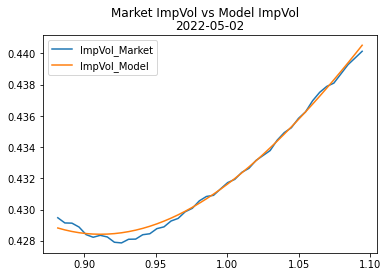

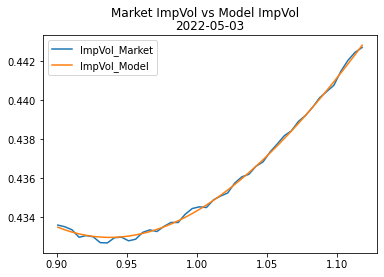

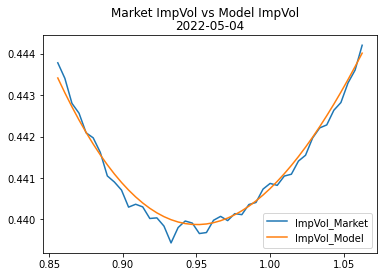

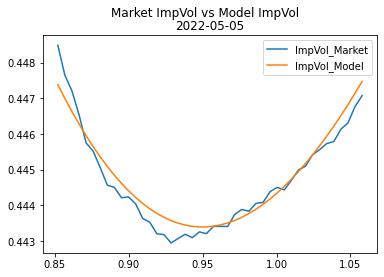

In [125]:
Param_list = [[6.42036677, 0.20238798, 1.61201301, 0.14342213, 0.20114263],
              [6.41886295, 0.20021133, 1.50618897, 0.09460406, 0.20605098],
              [6.35477026, 0.21725169, 1.55980139, 0.07661896, 0.20049433],
              [6.19907738, 0.21552632, 1.58377958, 0.07931718, 0.21154332] ]
dateList
for i in range(len(Param_list)):
  Param = Param_list[i]
  param = [p for p in Param]
  # param[4] = param[4] + param[0]*(param[1]-param[4])/252

  marketData_OutSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i],:].copy()

  plot_IV( param, marketData_OutSample)

lambda: 6.19907738 ; v_bar: 0.21552632 ; eta: 1.58377958 ; rho: 0.07931718 ; Vt: 0.21154332
Constraint 2*lambda*v_bar - eta**2/2:  1.417949791200795
MSE:  4.556015740592873e-05
Error:  0.0005522007798741688
#########################


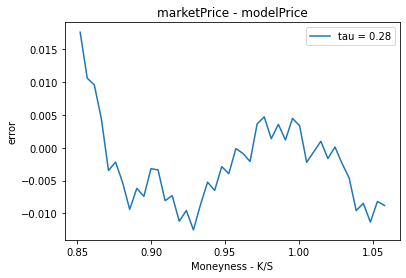

lambda: 6.19907738 ; v_bar: 0.21552632 ; eta: 1.58377958 ; rho: 0.07931718 ; Vt: 0.21154332
Constraint 2*lambda*v_bar - eta**2/2:  1.417949791200795
MSE:  0.052225735194797646
Error:  0.052732375817265885
#########################


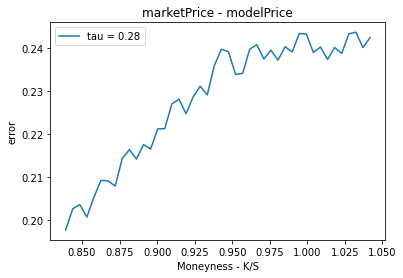

In [132]:
marketData_InSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i],:].copy()
marketData_OutSample = marketData_Tb.loc[marketData_Tb.Date == dateList[i+1],:].copy()

ErrorFunction2(Param , marketData_InSample, 1)
plotResult(marketData_InSample) 

ErrorFunction2(Param , marketData_OutSample, 1)
plotResult(marketData_OutSample) 

In [127]:
marketData_OutSample

,Date,S0,K,tau,r,PutPrice,ATM,CallPrice,ImpVol_Market,ModelCallPrice,ImpVol_Model,Moneyness_K_S,error
132,2022-05-05,104.453,89.0,0.2817,0.014,3.3200,0,19.1234,0.448492,19.105796,0.447388,0.852058,0.001104
133,2022-05-05,104.453,89.5,0.2817,0.014,3.4500,0,18.7553,0.447652,18.744699,0.446999,0.856845,0.000653
134,2022-05-05,104.453,90.0,0.2817,0.014,3.5900,0,18.3973,0.447209,18.387729,0.446630,0.861632,0.000579
135,2022-05-05,104.453,90.5,0.2817,0.014,3.7300,0,18.0393,0.446541,18.034938,0.446282,0.866418,0.000259
136,2022-05-05,104.453,91.0,0.2817,0.014,3.8717,0,17.6829,0.445750,17.686376,0.445954,0.871205,-0.000203
137,2022-05-05,104.453,91.5,0.2817,0.014,4.0267,0,17.3399,0.445520,17.342089,0.445646,0.875992,-0.000126
138,2022-05-05,104.453,92.0,0.2817,0.014,4.1817,0,16.9968,0.445057,17.002120,0.445358,0.880779,-0.000302
139,2022-05-05,104.453,92.5,0.2817,0.014,4.3400,0,16.6571,0.444565,16.666511,0.445090,0.885566,-0.000525
140,2022-05-05,104.453,93.0,0.2817,0.014,4.5100,0,16.3291,0.444502,16.335298,0.444843,0.890353,-0.000341
141,2022-05-05,104.453,93.5,0.2817,0.014,4.6800,0,16.0011,0.444213,16.008518,0.444615,0.895139,-0.000403
